# Setting up django server

In [ ]:
!pip install django

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.9 MB 17.4 MB/s 


In [ ]:
!django-admin startproject football_face_rec

In [ ]:
%cd football_face_rec/

/content/football_face_rec


In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8000)"))

https://sj94vzpi32-496ff2e9c6d22116-8000-colab.googleusercontent.com/


In [ ]:
ALLOWED_HOSTS = ['colab.research.google.com']

In [ ]:
!python manage.py runserver 8000

Watching for file changes with StatReloader
Performing system checks...

System check identified no issues (0 silenced).

You have 18 unapplied migration(s). Your project may not work properly until you apply the migrations for app(s): admin, auth, contenttypes, sessions.
Run 'python manage.py migrate' to apply them.
June 12, 2022 - 17:51:04
Django version 3.2.13, using settings 'football_face_rec.settings'
Starting development server at http://127.0.0.1:8000/
Quit the server with CONTROL-C.
Not Found: /
[12/Jun/2022 17:51:06] "GET / HTTP/1.1" 404 2190
Internal Server Error: /face_rec/
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/django/core/handlers/exception.py", line 47, in inner
    response = get_response(request)
  File "/usr/local/lib/python3.7/dist-packages/django/core/handlers/base.py", line 181, in _get_response
    response = wrapped_callback(request, *callback_args, **callback_kwargs)
  File "/content/football_face_rec/face_rec/views.py"

In [ ]:
!python manage.py startapp face_rec

# Face Detection Model

In [ ]:
!mkdir data
%cd data
!mkdir class1
!mkdir labels
%cd ../

/content/data
/content


In [ ]:
!mkdir aug_data
%cd aug_data
!mkdir test
%cd test
!mkdir images
!mkdir labels
!mkdir test
%cd ..
!mkdir train
%cd train
!mkdir images
!mkdir labels
%cd ..
!mkdir val
%cd val
!mkdir images
!mkdir labels
%cd ../../

/content/aug_data
/content/aug_data/test
/content/aug_data
/content/aug_data/train
/content/aug_data
/content/aug_data/val
/content


In [ ]:
! pip install tensorflow tensorflow-gpu opencv-python matplotlib albumentations



1.   Limit GPU




In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from PIL import Image
import splitfolders
import os
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices ('GPU')
for gpu in gpus :
  tf.config.experimental.set_memory_growth (gpu, True) 

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2. partition unaugmented data

In [ ]:
# not working
import os, sys

size = (2000, 2000)

for infile in os.listdir ( os.path.join ( 'data', 'images')):
    outfile = os.path.splitext(infile)[0] + ".thumbnail"
    if infile != outfile:
        try:
            im = Image.open(infile)
            im.thumbnail(size, Image.ANTIALIAS)
            im.save(os.path.join ( 'data' , 'resized'), "jpg")
        except IOError:
            print("cannot create thumbnail for " + infile)

In [ ]:
import splitfolders
splitfolders.ratio('./data', output="./data", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 308 files [00:00, 4028.16 files/s]


In [ ]:
for folder in [ 'train' , 'test' , 'val' ] :
  for file in os.listdir ( os.path.join ( 'data' , folder , 'class1' )):
    filename = file.split ( '.' ) [ 0 ] + '.json'
    existing_filepath = os . path.join ( 'data' , 'labels' , filename)
    if os . path.exists ( existing_filepath ) :
      new_filepath = os.path.join ( 'data' , folder , 'labels', filename)
      os.replace ( existing_filepath , new_filepath )

3. Apply image augmentation

In [ ]:
!pip install --upgrade albumentations

In [ ]:
!pip uninstall opencv-python

In [ ]:
!pip install opencv-python

In [ ]:
import albumentations as alb

In [ ]:
def augmentor_creator(size):
  augmentor = alb.Compose([alb.RandomSizedBBoxSafeCrop(width=450, height=450, erosion_rate=0.2),
                          alb.HorizontalFlip(p=0.5),
                          alb.RandomBrightnessContrast (p=0.2),
                          alb.RandomGamma (p=0.2),
                          alb.RGBShift(p=0.2) ,
                          alb.VerticalFlip(p=0.5)] ,
                          bbox_params=alb.BboxParams(format ='albumentations',
                          label_fields=['class_labels']))
  return augmentor

In [ ]:
for partition in ['train', 'test', 'val' ] :
  for image in os.listdir ( os.path.join ( 'data', partition, 'class1')):
    
    img = cv2.imread ( os.path.join ( 'data' , partition , 'class1', image))
    height = img.shape[0]
    width = img.shape[1]
    coords = [ 0,0,0.00001,0.00001 ]
    label_path = os.path.join ('data', partition, 'labels' , f'{( image.split (".") [0])}.json')
    if os.path.exists ( label_path ):
      with open ( label_path , 'r' ) as f:
        label = json.load ( f )
        coords [ 0 ] = label ['shapes'] [ 0 ] [ 'points' ] [ 0 ] [ 0 ]
        coords [ 1 ] = label ['shapes'] [ 0 ] [ 'points' ] [ 0 ] [ 1 ]
        coords [ 2 ] = label ['shapes'] [ 0 ] [ 'points' ] [ 1 ] [ 0 ]
        coords [ 3 ] = label ['shapes'] [ 0 ] [ 'points' ] [ 1 ] [ 1 ]
        coords = list(np.divide(coords , [width,height,width,height]))
    
    try:
      for x in range ( 60 ) :
        augmentor = augmentor_creator(size=[width,height])
        augmented = augmentor ( image = img , bboxes = [ coords ] , class_labels = ['face'] )
        cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
        
        annotation = {}
        annotation['image'] = image

        if os.path.exists(label_path):
          if len(augmented['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else: 
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

        with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
          json.dump(annotation, f)
    except Exception as e:
      print(e)
    

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



4. Load images into TenserFlow Dataset

In [ ]:
!unrar x "reco_data_final_split.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/reco_data_final_split/train/labels/340b81db31.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/340f007b59.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/342930e9dd.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/34465922fb.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/34537bf42c.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/3454324996.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/345aa2da31.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/346d6b3e50.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/3472dea17c.json      89%  OK 
Extracting  /content/reco_data_final_split/train/labels/34a7fe4cc9.json      89%  OK 

In [ ]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
train_images = tf.data.Dataset.list_files ( 'aug_data/train/images/*.jpg' , shuffle = False )
train_images = train_images.map ( load_image )
train_images = train_images.map ( lambda x : tf.image.resize ( x , ( 120,120 ) ) )
train_images = train_images.map ( lambda x : x / 255 )

In [ ]:
test_images = tf.data.Dataset.list_files ( 'aug_data/test/images/*.jpg' , shuffle = False )
test_images = test_images.map ( load_image )
test_images = test_images.map ( lambda x : tf.image.resize ( x , ( 120,120 ) ) )
test_images = train_images.map ( lambda x : x / 255 )

In [ ]:
val_images = tf.data.Dataset.list_files ( 'aug_data/val/images/*.jpg' , shuffle = False )
val_images = val_images.map ( load_image )
val_images = val_images.map ( lambda x : tf.image.resize ( x , ( 120,120 ) ) )
val_images = val_images.map ( lambda x : x / 255 )

In [ ]:
train_images.as_numpy_iterator ( ) .next ( )

array([[[0.26035538, 0.13725491, 0.15686275],
        [0.2586397 , 0.14491421, 0.16060048],
        [0.23970588, 0.14460784, 0.14509805],
        ...,
        [0.18480392, 0.19264705, 0.24362744],
        [0.2       , 0.20784314, 0.25539216],
        [0.209375  , 0.21721813, 0.26672795]],

       [[0.25490198, 0.14117648, 0.15949754],
        [0.2504902 , 0.14852941, 0.16029412],
        [0.23235294, 0.14803922, 0.14607844],
        ...,
        [0.18480392, 0.19264705, 0.24362744],
        [0.2       , 0.20784314, 0.25539216],
        [0.21207108, 0.21991421, 0.26942402]],

       [[0.24362744, 0.14460784, 0.16078432],
        [0.2357843 , 0.14803922, 0.15980393],
        [0.22751226, 0.14895834, 0.15294118],
        ...,
        [0.18480392, 0.19264705, 0.24362744],
        [0.2       , 0.20784314, 0.25539216],
        [0.21421568, 0.22205882, 0.27156863]],

       ...,

       [[0.26550245, 0.23314951, 0.21207108],
        [0.2514706 , 0.22303921, 0.19215687],
        [0.26366422, 0

5. Prepare labels

In [ ]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
    label = json.load(f)
  return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
len(train_images), len(test_images), len(test_images), len(train_labels)

(7445, 7445, 7445, 7445)

6. Create final datasets

In [ ]:
train = tf.data.Dataset.zip ( ( train_images , train_labels ) )
train = train.shuffle ( 5000 )
train = train.batch ( 8 )
train = train.prefetch ( 4 )

In [ ]:
test = tf.data.Dataset.zip ( ( test_images , test_labels ) )
test = test.shuffle ( 1300 )
test = test.batch ( 8 )
test = test.prefetch ( 4 )

In [ ]:
val = tf.data.Dataset.zip ( ( val_images , val_labels ) )
val = val.shuffle ( 1000 )
val = val.batch ( 8 )
val = val.prefetch ( 4 )

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8), array([[0.2135, 0.2932, 0.8667, 1.    ],
        [0.1072, 0.    , 0.931 , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1003, 0.2262, 1.    , 0.7993],
        [0.547 , 0.6196, 0.8916, 1.    ],
        [0.0628, 0.141 , 0.8784, 0.9424],
        [0.2454, 0.    , 0.526 , 1.    ],
        [0.3457, 0.6265, 0.616 , 1.    ]], dtype=float16))

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


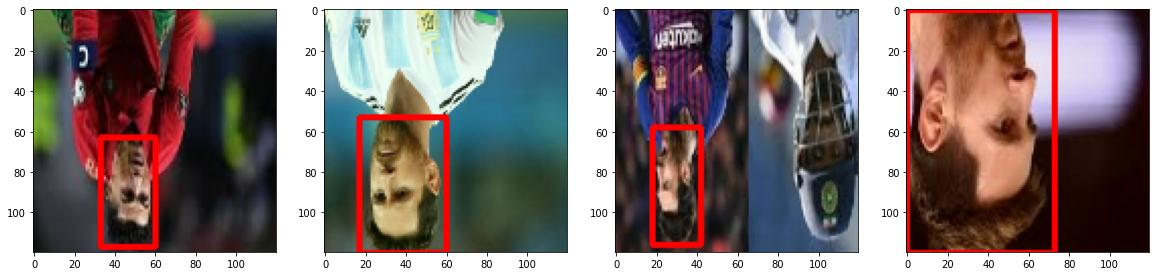

In [ ]:
fig , ax = plt.subplots ( ncols = 4 , figsize = ( 20,20 ) )
for idx in range ( 4 ) :
  sample_image = res [ 0 ] [ idx ]
  sample_coords = res [ 1 ] [ 1 ] [ idx ]
  cv2.rectangle ( sample_image ,
  tuple ( np.multiply ( sample_coords [ : 2 ] ,
  [ 120,120 ] ) . astype ( int ) ) ,
  tuple ( np.multiply ( sample_coords [ 2 : ] , [ 120,120 ] ) . astype ( int ) ) ,
  ( 255,0,0 ) , 2 )
  ax [ idx ] .imshow ( sample_image )

7. build deep learning stack


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

In [ ]:
def build_model():
  input_layer =  Input(shape = (120,120,3))

  vgg = VGG16(include_top = False)(input_layer)

  # Classification
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation = 'relu')(f1)
  out_class = Dense(1, activation ='sigmoid')(class1)
   
  # Bounding box regression
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation = 'relu')(f2)
  out_regress = Dense(4, activation = 'sigmoid')(regress1)
  facetracker = Model ( inputs = input_layer, outputs = [out_class,out_regress])
  
  return facetracker

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [ ]:
X, Y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
classes, coords

(array([[0.5164428 ],
        [0.5198708 ],
        [0.47465447],
        [0.52348435],
        [0.5021823 ],
        [0.5923893 ],
        [0.62952197],
        [0.61106974]], dtype=float32),
 array([[0.3792299 , 0.44044122, 0.31634864, 0.38086858],
        [0.40058225, 0.48288974, 0.2896728 , 0.6445214 ],
        [0.3664338 , 0.41469568, 0.20009854, 0.4022905 ],
        [0.4162463 , 0.399435  , 0.27644888, 0.35515827],
        [0.3923215 , 0.49922895, 0.3224059 , 0.41820538],
        [0.41003418, 0.5532068 , 0.28751805, 0.32492387],
        [0.4419088 , 0.40125868, 0.20695242, 0.41135365],
        [0.3957144 , 0.40931994, 0.21380225, 0.4029838 ]], dtype=float32))

10. Define losses and optimizers

In [ ]:
# Specifiying how many batches in one epoch and how much the learning rate will drop after each epoch
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

Localization loss function
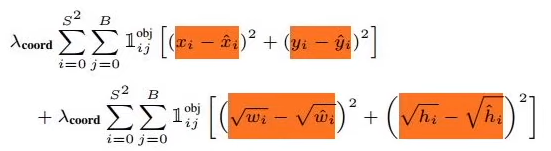

In [ ]:
# Defining the localization loss function
def localization_loss(y_true, y_hat):
  # calulating the difference in coords
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:,:2]))

  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]

  h_pred = y_hat[:,3] - y_hat[:,1]
  w_pred = y_hat[:,2] - y_hat[:,0]

  # calculating the height and width difference
  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

  return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryFocalCrossentropy()
regressloss = localization_loss

In [ ]:
regressloss(Y[1], coords).numpy()

9.23963

In [ ]:
classloss(Y[0], classes).numpy()

0.13170712

11. Create the model

In [ ]:
class FaceTracker(Model):
  def __init__(self, facetracker, **kwargs):
    super().__init__(**kwargs)
    self.model = facetracker
  
  def compile(self, opt, classloss, regressloss, **kwargs):
    super().compile(**kwargs)
    self.classloss = classloss
    self.regressloss = regressloss
    self.opt = opt

  def train_step(self, batch, **kwargs):
    X, Y = batch
    with tf.GradientTape() as tape:
      classes, coords = self.model(X, training=True)

      # Calculating the losses
      batch_classloss = self.classloss(Y[0], classes)
      batch_regressloss = self.regressloss(tf.cast(Y[1], tf.float32), tf.cast(coords, tf.float32))

      # summing the losses
      total_loss = batch_regressloss + 0.5 * batch_classloss

      # calculate the gradient for each one of the model's variables
      grad = tape.gradient(total_loss, self.model.trainable_variables)

    # Apply the gradients using the optimizer
    opt.apply_gradients(zip(grad, self.model.trainable_variables))
    
    return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_regressloss}

  def test_step(self, batch, **kwargs):
    X, Y = batch
    classes, coords = self.model(X, training=False)

    # Calculating the losses
    batch_classloss = self.classloss(Y[0], classes)
    batch_regressloss = self.regressloss(tf.cast(Y[1], tf.float32), coords)

    # summing the losses
    total_loss = batch_regressloss + 0.5 * batch_classloss

    return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_regressloss}



In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt,classloss,regressloss)

12. Training the model

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

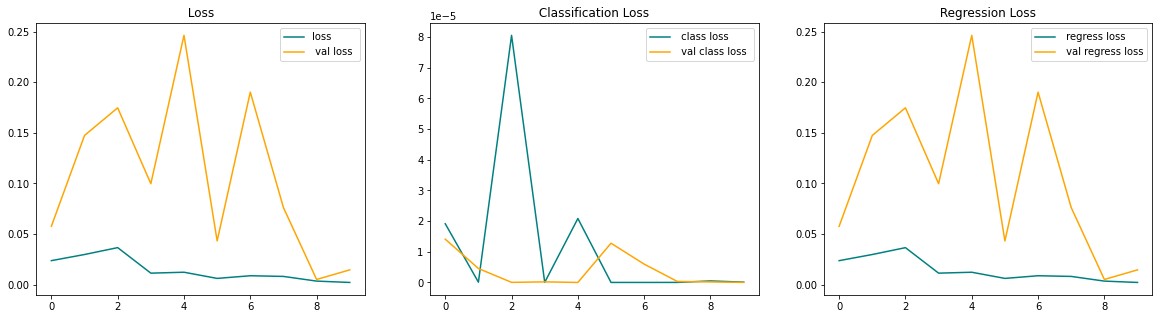

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot( hist.history [ 'val_total_loss' ] , color = 'orange' , label = ' val loss ' )
ax[0].title.set_text ( ' Loss ' )
ax[0].legend()
ax[1].plot(hist.history [ 'class_loss' ] , color = 'teal' , label = ' class loss ' )
ax[1].plot(hist.history [ 'val_class_loss' ] , color = 'orange' , label = ' val class loss ' )
ax[1].title.set_text(' Classification Loss ' )
ax[1].legend ( )

ax[2].plot ( hist.history [ 'regress_loss' ] , color = 'teal' , label = ' regress loss ' )
ax[2].plot ( hist.history [ 'val_regress_loss' ] , color = 'orange' , label = ' val regress loss')
ax[2].title.set_text ( ' Regression Loss ' )
ax[2].legend ( )
plt.show ( )

13. Testing the model

In [ ]:
test_data = val.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
y_hat = facetracker.predict(test_sample[0])

In [ ]:
y_hat

[array([[0.99992526],
        [0.99620336],
        [0.99874145],
        [0.99897075],
        [0.99883217],
        [0.997663  ],
        [0.99888545],
        [0.99861276]], dtype=float32),
 array([[0.22169591, 0.12444156, 0.953599  , 0.99551743],
        [0.01272434, 0.429067  , 0.49782038, 0.98465157],
        [0.0130225 , 0.21180457, 0.5322202 , 0.987463  ],
        [0.3694411 , 0.23875095, 0.9119986 , 0.91505486],
        [0.5450493 , 0.12759262, 0.84130144, 0.6528344 ],
        [0.41209212, 0.00596721, 0.61131465, 0.39928478],
        [0.21720569, 0.59702724, 0.5993842 , 0.9917026 ],
        [0.47431338, 0.00396067, 0.87720793, 0.4208292 ]], dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


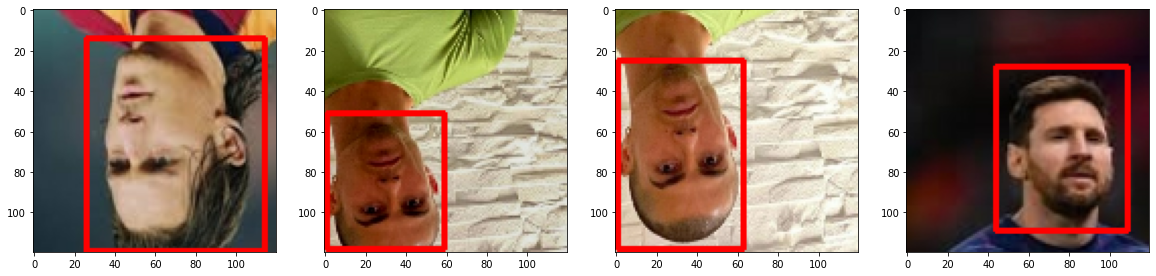

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,5))
for idx in range(4):
  sample_image = test_sample[0][idx]
  sample_coords = y_hat[1][idx]

  if y_hat[0][idx] > 0.5:
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),2)
    ax[idx].imshow(sample_image)

14. Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

In [ ]:
image = cv2.imread('tarik.jpg')
image = image[50:1000, 50:1000, :]
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))
yhat = facetracker.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]
if yhat[0] > 0.5:
  cv2.rectangle(image,
                  tuple(np.multiply(sample_coords[:2], [950,950]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [950,950]).astype(int)),
                  (255,0,0),2)
  plt.imshow(image)

NameError: ignored

[array([[0.9975688]], dtype=float32),
 array([[0.474664 , 0.0465963, 0.8561505, 0.8274561]], dtype=float32)]

# Face Recognition Model Setup

Installing the dependecies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

Importing the dependecies

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from PIL import Image
import json

1. Building the embedding layer 

The embedding layer follows the shape of the figure bellow without the L1 siamese dist layer
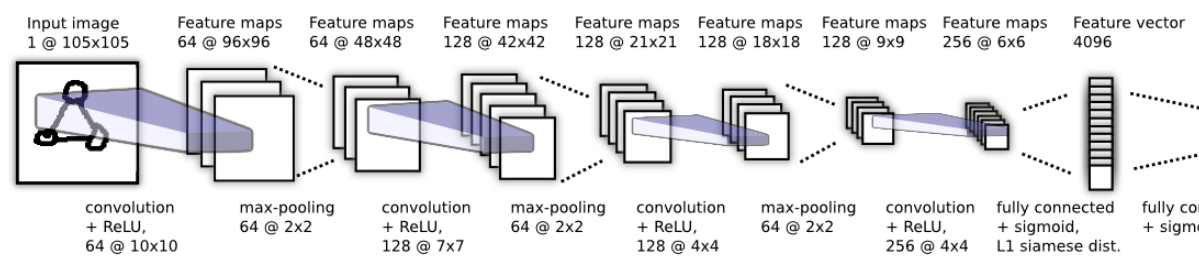

In [ ]:
def make_classifier():
  inp = Input(shape=(100,100,3), name='input_image')

  #block 1
  vgg = VGG16(include_top = False)(inp)

  # block 2
  f1 = GlobalMaxPooling2D()(vgg)
  d1 = Dense(4096, activation='sigmoid')(f1)

  # classifier
  d2 = Dense(22, activation='softmax')(d1)

  return Model(inputs=[inp], outputs=[d2], name='classifier')


In [ ]:
model = make_classifier()
model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_max_pooling2d_8 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_22 (Dense)            (None, 4096)              2101248   
                                                                 
 dense_23 (Dense)            (None, 22)                90134     
                                                                 
Total params: 16,906,070
Trainable params: 16,906,070
Non-trainable params: 0
____________________________________________

2. Defining optimizer and loss function

In [ ]:
# Specifiying how many batches in one epoch and how much the learning rate will drop after each epoch
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

3. Training the model

 3.1 Extracting faces from data set images



In [ ]:
!mkdir data
%cd data
!mkdir class1
!mkdir class2
!mkdir class3
!mkdir class4
!mkdir class5
!mkdir class6
!mkdir class7
!mkdir class8
!mkdir class9
!mkdir class10
!mkdir class11
!mkdir class12
!mkdir class13
!mkdir class14
!mkdir class15
!mkdir class16
!mkdir class17
!mkdir class18
!mkdir class19
!mkdir class20
!mkdir class21
!mkdir class22

/content/data


In [ ]:
%cd ../

/content


In [ ]:
!mkdir reco_data
%cd reco_data
!mkdir class1
!mkdir class2
!mkdir class3
!mkdir class4
!mkdir class5
!mkdir class6
!mkdir class7
!mkdir class8
!mkdir class9
!mkdir class10
!mkdir class11
!mkdir class12
!mkdir class13
!mkdir class14
!mkdir class15
!mkdir class16
!mkdir class17
!mkdir class18
!mkdir class19
!mkdir class20
!mkdir class21
!mkdir class22

In [ ]:
%cd ../

In [ ]:
!mkdir reco_data_final
%cd reco_data_final
!mkdir class1
!mkdir class2
!mkdir class3
!mkdir class4
!mkdir class5
!mkdir class6
!mkdir class7
!mkdir class8
!mkdir class9
!mkdir class10
!mkdir class11
!mkdir class12
!mkdir class13
!mkdir class14
!mkdir class15
!mkdir class16
!mkdir class17
!mkdir class18
!mkdir class19
!mkdir class20
!mkdir class21
!mkdir class22

In [ ]:
%cd ../

In [ ]:
!zip -r /content/data.zip /content/data

In [ ]:
from google.colab import files
files.download("/content/data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
facetracker = load_model('facetracker.h5')

In [ ]:
for Class in ['class1','class2','class3','class4',
              'class5','class6','class7','class8',
              'class9','class10','class11','class12',
              'class13','class14','class15','class16',
              'class17','class18','class19','class20',
              'class21','class22']:
  for image in os.listdir(os.path.join('data', Class)):
    img = cv2.imread(os.path.join('data', Class, image))
    height = img.shape[0]
    width = img.shape[1]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    coord1 = tuple(np.multiply(sample_coords[:2], [width,height]).astype(int))
    coord2 = tuple(np.multiply(sample_coords[2:], [width,height]).astype(int))
    w = coord1[0] + (coord2[0]-coord1[0])
    h = coord1[1] + (coord2[1]-coord1[1])
    img = Image.open(os.path.join('data', Class, image))
    box = (coord1[0], coord1[1], w, h)
    img2 = img.crop(box)
    try:
      img2.save('./reco_data/'+Class+'/'+image)
    except:
      pass


In [ ]:
!zip -r /content/reco_data.zip /content/reco_data

3.2 cleaning the new dataset

In [ ]:
for Class in ['class1','class2','class3','class4',
              'class5','class6','class7','class8',
              'class9','class10','class11','class12',
              'class13','class14','class15','class16',
              'class17','class18','class19','class20',
              'class21','class22']:
  for image in os.listdir(os.path.join('reco_data', Class)):
    try:
      img = cv2.imread(os.path.join('reco_data', Class, image))
      height = img.shape[0]
      width = img.shape[1]
      rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      resized = tf.image.resize(rgb, (120,120))
      yhat = facetracker.predict(np.expand_dims(resized/255,0))
      if yhat[0][0][0] > 0.9:
        img = Image.open(os.path.join('reco_data', Class, image))
        img.save('./reco_data_final/'+Class+'/'+image)
    except:
      pass


In [ ]:
!zip -r /content/reco_data_final.zip /content/reco_data_final

In [ ]:
import splitfolders
splitfolders.ratio('./reco_data_final', output="./reco_data_final_split", seed=1337, ratio=(.8, 0.1,0.1)) 

In [ ]:
!zip -r /content/reco_data_final_split.zip /content/reco_data_final_split

In [ ]:
coord1, coord2

3.3 Labeling the dataset

In [ ]:
for partition in ['train', 'test', 'val']:
  for Class in ['class1','class2','class3','class4',
                'class5','class6','class7','class8',
                'class9','class10','class11','class12',
                'class13','class14','class15','class16',
                'class17','class18','class19','class20',
                'class21','class22']:
    for image in os.listdir(os.path.join('reco_data_final_split', partition, Class)):
      with open(os.path.join('reco_data_final_split', partition, 'labels', f'{image.split(".")[0]}.json'), 'w', encoding='utf-8') as jsonf: 
        aDict = {}
        if Class == 'class1':
          aDict = {'class1': 1,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class2':
          aDict = {'class1': 0,'class2': 1,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class3':
          aDict = {'class1': 0,'class2': 0,'class3' : 1,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class4':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 1,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class5':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 1,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class6':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 1,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class7':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 1,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class8':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 1,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class9':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 1,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class10':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 1,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class11':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 1,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class12':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 1,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class13':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 1,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class14':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 1,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class15':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 1,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class16':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 1,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class17':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 1,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class18':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 1,'class19': 0,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class19':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 1,'class20': 0,
                'class21': 0,'class22': 0 }
        if Class == 'class20':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 1,
                'class21': 0,'class22': 0 }
        if Class == 'class21':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 1,'class22': 0 }
        if Class == 'class22':
          aDict = {'class1': 0,'class2': 0,'class3' : 0,'class4': 0,
                'class5': 0,'class6': 0,'class7': 0,'class8': 0,
                'class9': 0,'class10': 0,'class11': 0,'class12': 0,
                'class13': 0,'class14': 0,'class15': 0,'class16': 0,
                'class17': 0,'class18': 0,'class19': 0,'class20': 0,
                'class21': 0,'class22': 1 }
        json.dump(aDict, jsonf)
        


In [ ]:
!zip -r /content/reco_data_final_split.zip /content/reco_data_final_split

In [ ]:
for partition in ['train','test','val']:

  for f in os.listdir(os.path.join('reco_data_final_split', partition, 'labels')):
    
    i = 0
  
    for image in os.listdir(os.path.join('reco_data_final_split', partition)):
      
      if f'{image.split(".")[0]}' == f'{f.split(".")[0]}':
        print('hi')
        i = 1
        break
    if i == 0:
      os.remove(os.path.join('reco_data_final_split', partition, 'labels', f))


In [ ]:
countf = 0
for partition in ['train']:
  for f in os.listdir(os.path.join('reco_data_final_split', partition, 'labels')):
    countf = countf + 1

In [ ]:
countf 

4490

In [ ]:
counti = 0
for partition in ['train']:
  for i in os.listdir(os.path.join('reco_data_final_split', partition)):
    counti = counti + 1

In [ ]:
counti

4491

In [ ]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
train_images = tf.data.Dataset.list_files ( 'reco_data_final_split/train/*.jpg' , shuffle = False )
train_images = train_images.map ( load_image )
train_images = train_images.map ( lambda x : tf.image.resize ( x , ( 100,100 ) ) )
train_images = train_images.map ( lambda x : x / 255 )

In [ ]:
test_images = tf.data.Dataset.list_files ( 'reco_data_final_split/test/*.jpg' , shuffle = False )
test_images = test_images.map ( load_image )
test_images = test_images.map ( lambda x : tf.image.resize ( x , ( 100,100 ) ) )
test_images = train_images.map ( lambda x : x / 255 )

In [ ]:
val_images = tf.data.Dataset.list_files ( 'reco_data_final_split/val/*.jpg' , shuffle = False )
val_images = val_images.map ( load_image )
val_images = val_images.map ( lambda x : tf.image.resize ( x , ( 100,100 ) ) )
val_images = val_images.map ( lambda x : x / 255 )

In [ ]:
train_images.as_numpy_iterator ( ) .next ( )

In [ ]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
    label = json.load(f)
  return [label['class1'],label['class2'],label['class3'],label['class4'],
          label['class5'],label['class6'],label['class7'],label['class8'],
          label['class9'],label['class10'],label['class11'],label['class12'],
          label['class13'],label['class14'],label['class15'],label['class16'],
          label['class17'],label['class18'],label['class19'],label['class20'],
          label['class21'],label['class22']]

In [ ]:
train_labels = tf.data.Dataset.list_files('reco_data_final_split/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32]))

In [ ]:
test_labels = tf.data.Dataset.list_files('reco_data_final_split/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32]))

In [ ]:
val_labels = tf.data.Dataset.list_files('reco_data_final_split/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32]))

In [ ]:
train_labels.as_numpy_iterator().next()

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

In [ ]:
train = tf.data.Dataset.zip ( ( train_images , train_labels ) )
train = train.shuffle ( 5000 )
train = train.batch ( 1 )
train = train.prefetch ( 4 )

In [ ]:
test = tf.data.Dataset.zip ( ( test_images , test_labels ) )
test = test.shuffle ( 1300 )
test = test.batch ( 1 )
test = test.prefetch ( 4 )

In [ ]:
val = tf.data.Dataset.zip ( ( val_images , val_labels ) )
val = val.shuffle ( 1000 )
val = val.batch ( 1 )
val = val.prefetch ( 4 )

In [ ]:
train.as_numpy_iterator().next()

(array([[[[0.8156863 , 0.80784315, 0.70980394],
          [0.8480784 , 0.8402353 , 0.7421961 ],
          [0.9062745 , 0.89843136, 0.8003921 ],
          ...,
          [0.6509804 , 0.78039217, 0.85490197],
          [0.6509804 , 0.78039217, 0.85490197],
          [0.6509804 , 0.78039217, 0.85490197]],
 
         [[0.8492157 , 0.8376471 , 0.73588234],
          [0.860177  , 0.8486083 , 0.7479426 ],
          [0.87987006, 0.86830145, 0.7696103 ],
          ...,
          [0.64911765, 0.7785294 , 0.8530392 ],
          [0.64911765, 0.7785294 , 0.8530392 ],
          [0.64911765, 0.7785294 , 0.8530392 ]],
 
         [[0.8843137 , 0.86813724, 0.7612745 ],
          [0.87361276, 0.8574363 , 0.75259805],
          [0.8543873 , 0.8382108 , 0.7370098 ],
          ...,
          [0.64754903, 0.7759804 , 0.85      ],
          [0.64754903, 0.7759804 , 0.85      ],
          [0.64754903, 0.7759804 , 0.85      ]],
 
         ...,
 
         [[0.7029412 , 0.25539216, 0.2960785 ],
          [0.70279

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

4490/4490 [==============================] - 118s 23ms/step - loss: 3.7521 - accuracy: 0.0000e+00 - val_loss: 3.4097 - val_accuracy: 0.0000e+00


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
y_hat = model.predict(test_sample[0])

In [ ]:
test_sample,y_hat

((array([[[[0.00146204, 0.0009853 , 0.00095454],
           [0.00153714, 0.0010604 , 0.00102964],
           [0.00160263, 0.0011028 , 0.00108089],
           ...,
           [0.00142937, 0.00116794, 0.00101415],
           [0.0014709 , 0.00120946, 0.00105567],
           [0.0014709 , 0.00120946, 0.00105567]],
  
          [[0.00144921, 0.00098785, 0.00095709],
           [0.00148389, 0.00101007, 0.00097932],
           [0.00152161, 0.00102872, 0.00100335],
           ...,
           [0.00140308, 0.00114164, 0.00098785],
           [0.00142922, 0.00116778, 0.00101399],
           [0.00142922, 0.00116778, 0.00101399]],
  
          [[0.00142953, 0.00096817, 0.00093741],
           [0.00143356, 0.00095974, 0.00092899],
           [0.00149848, 0.00100559, 0.00098022],
           ...,
           [0.0013887 , 0.00111534, 0.00096155],
           [0.00141484, 0.00114148, 0.0009877 ],
           [0.00141484, 0.00114148, 0.0009877 ]],
  
          ...,
  
          [[0.00161218, 0.00115726, 0.00